In [514]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt

import decoder

In [642]:
# logfile = "logs/networks/regular/nodes-8-degree-2-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-16-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-4-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-4-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items-gain.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-16-seed-0-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-256-degree-128-seed-1-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-16-degree-8-seed-0-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
logfile = "logs/networks/regular/nodes-512-degree-32-seed-7-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"

rounds = []
with open(logfile) as f:
    for line in f:
        rounds.append(json.loads(line, cls=decoder.TorchTensorDecoder))
# rounds = rounds[:128]
print(len(rounds))

171


Text(0, 0.5, 'STD[params] in each node')

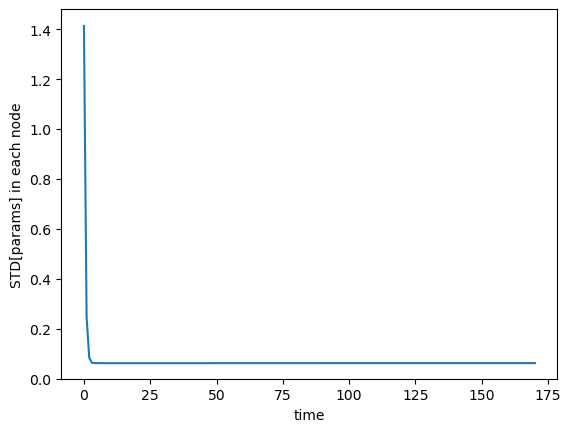

In [643]:
x = [r["round"] for r in rounds]
y = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
plt.plot(x, np.array(y))
plt.ylim(0, None)
#plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

In [644]:
np.min(y), y[-1]

(0.06233493238687515, 0.06246383860707283)

Text(0, 0.5, 'STD[param] across node')

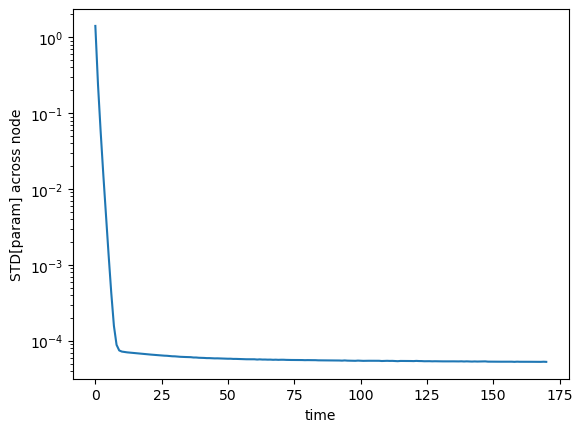

In [645]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x, y)
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

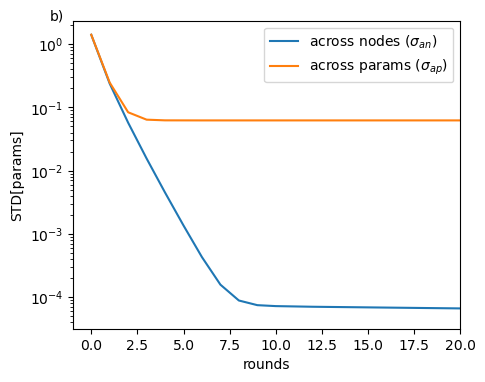

In [646]:
fig, ax = plt.subplots(figsize=(5, 4))
x = [r["round"] for r in rounds]
y_ap = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
y_an = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]

ax.plot(x, np.array(y_an), label="across nodes ($\\sigma_{an}$)")
ax.plot(x, np.array(y_ap), label="across params ($\\sigma_{ap}$)")
ax.set_xlim(-1, 20)
# ax.set_ylim(2e-5, 7e-1)
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("STD[params]")
ax.text(-0.06, 1.0, "b)", transform=ax.transAxes)
fig.savefig("figures/params_stds.pdf")

Text(0, 0.5, '$|\\delta(param)|$')

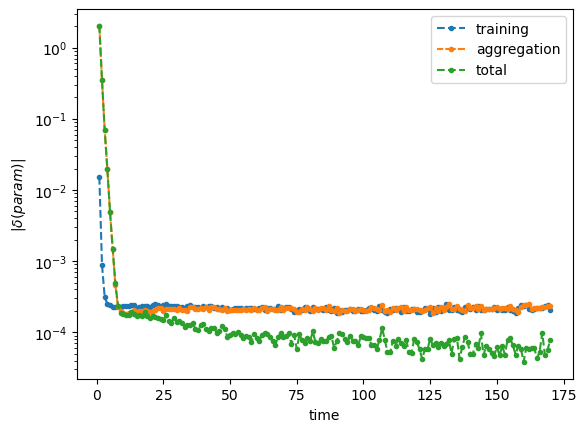

In [647]:
x = [r["round"] for r in rounds[1:]]
y1 = [r["training_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y2 = [r["aggregation_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y3 = [(r["aggregation_changes"]['0']["fc4.weight"] + r["training_changes"]['0']["fc4.weight"]).abs().mean()
      for r in rounds[1:]]
plt.plot(x, y1, label="training", marker=".", ls='--')
plt.plot(x, y2, label="aggregation", marker=".", ls=(2, (5, 1)))
plt.plot(x, y3, label="total", marker=".", ls='--')
plt.yscale("log")
plt.legend()
plt.xlabel("time")
plt.ylabel("$|\delta(param)|$")

0.31262704686868237

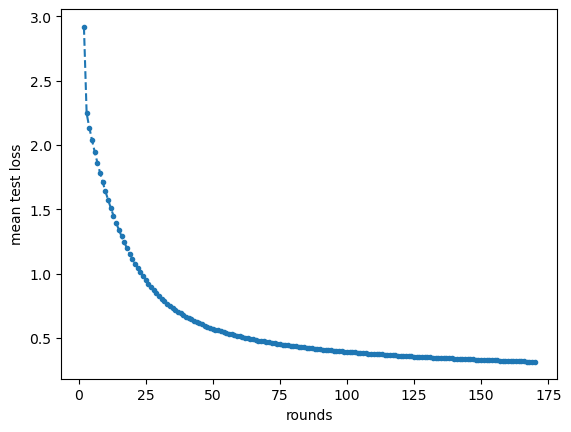

In [648]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_losses"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[2:], y[2:], yerr=yerr[2:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test loss")
y[-1]

Text(0, 0.5, 'mean test accuracy')

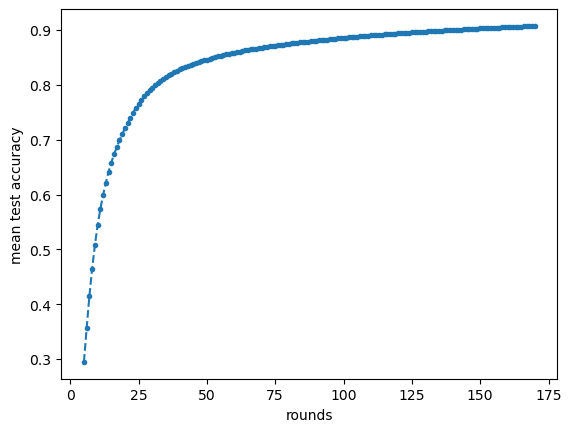

In [649]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_accuracies"])
y = np.array([np.mean([r["test_accuracies"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_accuracies"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[5:], y[5:], yerr=yerr[5:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test accuracy")

In [650]:
y[-1]

0.9073560546875

Text(0, 0.5, '-diff[mean test loss]')

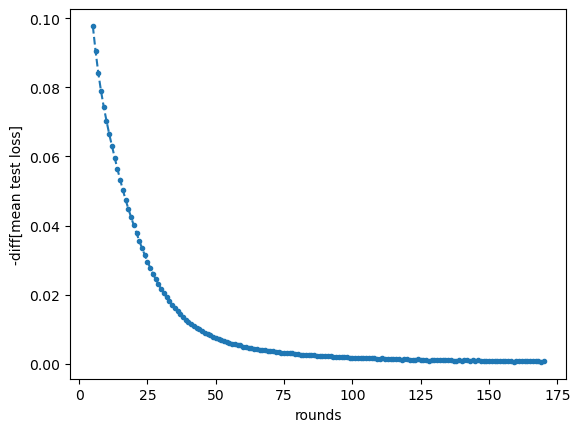

In [651]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
plt.plot(x[5:], -np.diff(y)[4:], marker=".", ls='--')
#plt.yscale("log")
#plt.ylim(1e-30, 1e-5)
plt.xlabel("rounds")
plt.ylabel("-diff[mean test loss]")

In [652]:
y[-2] - y[-1]

0.0009388331944588657

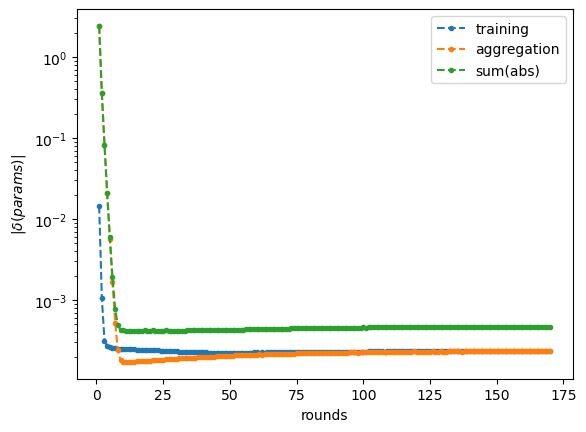

In [660]:
def cosine_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

min_t = 1
x = [r["round"] for r in rounds[min_t:]]
nodes = list(rounds[0]["test_losses"])

param = "fc4.weight"
y_train = []
y_agg = []
y_total = []
y_sum_abs = []
y_train_agg_sim = []
for n in nodes:
    y_train.append([r["training_changes"][n][param].abs().mean() for r in rounds[min_t:]])
    y_agg.append([r["aggregation_changes"][n][param].abs().mean() for r in rounds[min_t:]])
    y_sum_abs.append([(r["aggregation_changes"][n][param].abs() + r["training_changes"][n][param].abs()).mean()
          for r in rounds[min_t:]])
    y_total.append([(r["aggregation_changes"][n][param] + r["training_changes"][n][param]).abs().mean()
          for r in rounds[min_t:]])
    y_train_agg_sim.append([cosine_sim(r["training_changes"][n][param], r["aggregation_changes"][n][param])
                            for r in rounds[min_t:]])
plt.plot(x, np.mean(y_train, axis=0), label="training", marker=".", ls='--')
plt.plot(x, np.mean(y_agg, axis=0), label="aggregation", marker=".", ls='--')
# plt.plot(x, np.mean(y_total, axis=0), label="total", marker=".", ls='--')
plt.plot(x, np.mean(y_sum_abs, axis=0), label="sum(abs)", marker=".", ls='--')
# plt.plot(x, np.mean(y_total, axis=0)/np.mean(y_sum_abs, axis=0), label="total/sum(abs)", marker=".", ls='--')
plt.yscale("log")
plt.ylabel("$|\\delta(params)|$")
plt.xlabel("rounds")
plt.legend()

# plt.twinx().errorbar(
#     x, np.mean(y_train_agg_sim, axis=0), yerr=np.std(y_train_agg_sim, axis=0), marker=".", ls='--', color="tab:olive")
# plt.twinx().plot(
#     x, np.mean(np.exp(20*y_train_agg_sim), axis=0), marker=".", ls='--', color="tab:gray")
# plt.yscale("log")
# plt.ylabel("$S_c(\\delta_{training}, \\delta_{aggregation})$")

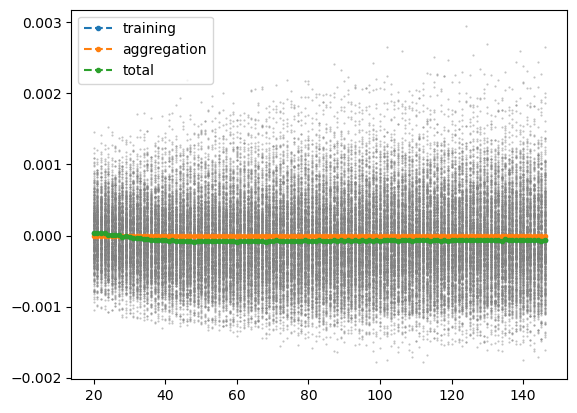

In [527]:
min_t = 20
x = [r["round"] for r in rounds[min_t:]]
idx = 10
y_train = []
y_agg = []
y_total = []
for n in nodes:
    y_train.append([r["training_changes"][n][param][idx] for r in rounds[min_t:]])
    y_agg.append([r["aggregation_changes"][n][param][idx] for r in rounds[min_t:]])
    y_total.append([(r["aggregation_changes"][n][param] + r["training_changes"][n][param])[idx]
          for r in rounds[min_t:]])
plt.plot(x, np.mean(y_train, axis=0), label="training", marker=".", ls='--')
plt.plot(np.repeat(np.array(x)[np.newaxis, :], len(nodes), axis=0), y_train, marker=".", ms=1, ls='', color="grey", alpha=0.5)

plt.plot(x, np.mean(y_agg, axis=0), label="aggregation", marker=".", ls='--')
plt.plot(x, np.mean(y_total, axis=0), label="total", marker=".", ls='--')
plt.legend()

Text(0, 0.5, 'STD[params] in each node')

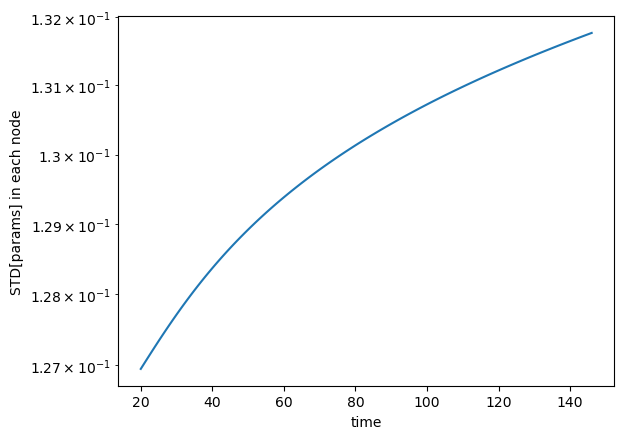

In [528]:
x = [r["round"] for r in rounds]
y = [np.mean([r["stds_across_params"][n][param] for n in nodes]) for r in rounds]
plt.plot(x[min_t:], y[min_t:])
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

Text(0, 0.5, 'STD[param] across node')

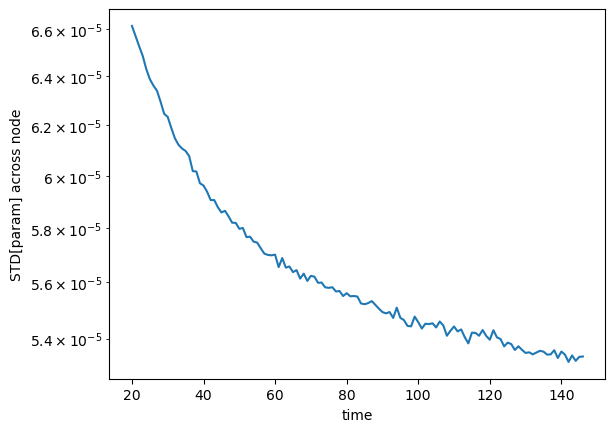

In [529]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x[min_t:], y[min_t:])
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

# Update/Data ratio

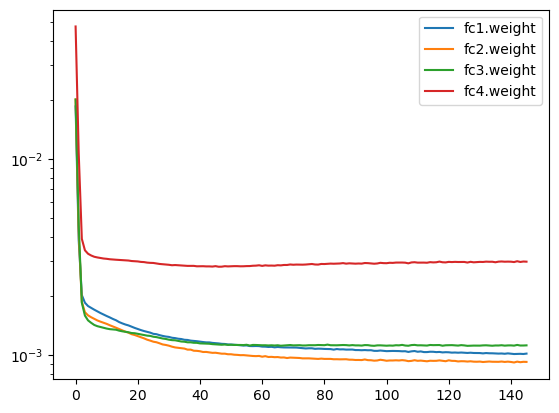

In [530]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    du = []
    for r in rounds[1:]:
        du.append([
            (r["training_changes"][n][param].std()/r["params"][n][param].std()).tolist()
            for n in nodes])
    ax.plot(np.mean(du, axis=1), label=param)
ax.legend()
ax.set_yscale("log")

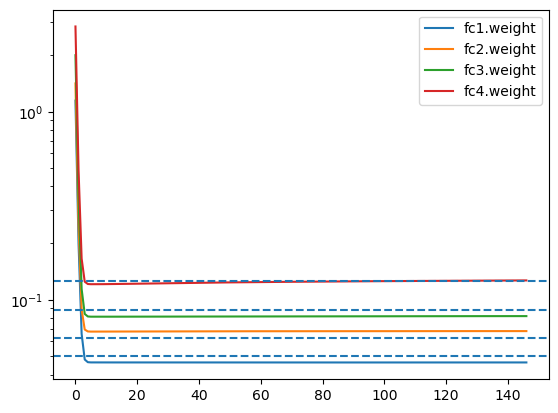

In [531]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
fan_ins = {"fc1.weight": 784, "fc2.weight": 512, "fc3.weight": 256, "fc4.weight": 128}
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    stds = []
    for r in rounds:
        weights = []
        for n in nodes:
            weights.extend(r["params"][n][param].tolist())
        stds.append(np.std(weights))
    ax.plot(stds, label=param)
    ax.axhline((2/fan_ins[param])**0.5, ls='--')
    
ax.set_yscale("log")
ax.legend()

# Scaling with size

In [817]:
import pathlib
from tqdm import tqdm

test_losses = {}

for size in [512, 256, 128, 64]:
    files = pathlib.Path("logs/networks/regular/").glob(f"nodes-{size}-degree-32-seed-*-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl")
    for logfile in tqdm(list(files)):
        with open(logfile) as f:
            test_loss = []
            for line in f:
                j = json.loads(line, cls=decoder.TorchTensorDecoder)
                test_loss.append(np.mean(list(j["test_losses"].values())))
            if size not in test_losses:
                test_losses[size] = []
            test_losses[size].append(test_loss)
# rounds = rounds[:128]

100%|██████████| 18/18 [09:10<00:00, 30.61s/it]


512 0.2922979106517625
256 0.3024020913211978
128 0.2145438048580452
64 0.2465536825489511


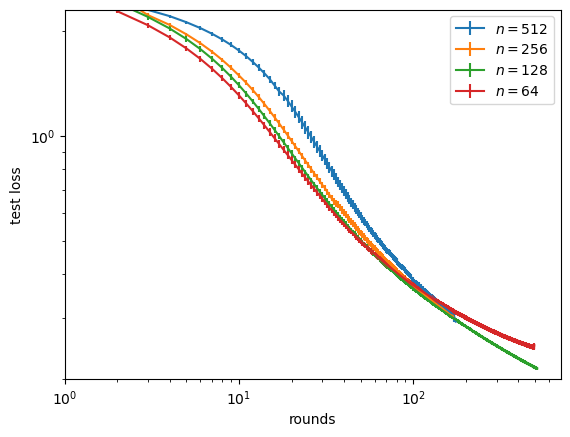

In [818]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.errorbar(
            x=np.arange(max_len),
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            label=f"$n={size}$")
    print(size, np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.set_xlim(1, None)
ax.set_ylim(2e-1, np.log(10))
ax.legend()
fig.savefig("figures/test_loss_scaling_size.pdf")

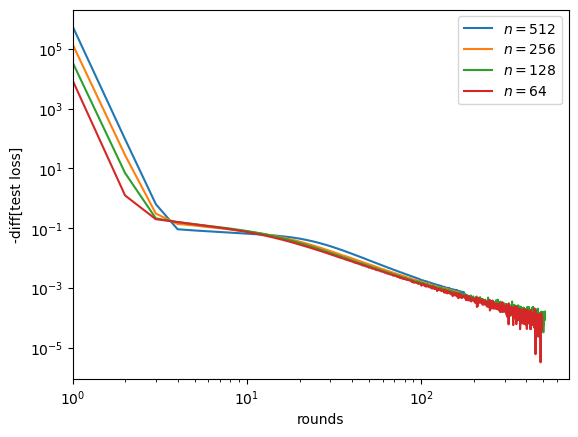

In [819]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.plot(np.arange(1, max_len),
            np.nanmean(-np.diff(loss), axis=0),
            # yerr=1.96*(np.nanstd(loss, axis=0)/(np.sum(np.array(loss) != np.nan, axis=0) - 1)**0.5),
            label=f"$n={size}$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("-diff[test loss]")
ax.set_xlim(1, None)
# ax.set_ylim(3e-1, np.log(10))
ax.legend()

# Isolated node scaling

In [663]:
isolated_test_losses = {}

for items in [51200, 25600, 12800, 6400]:
    files = pathlib.Path("logs/networks/isolated/").glob(f"seed-*-init-4-epochs-simple-balanced_iid-{items}-items.jsonl")
    for logfile in tqdm(list(files)):
        with open(logfile) as f:
            test_loss = []
            for line in f:
                j = json.loads(line, cls=decoder.TorchTensorDecoder)
                test_loss.append(j["test_losses"])
            if items not in isolated_test_losses:
                isolated_test_losses[items] = []
            isolated_test_losses[items].append(test_loss)
# rounds = rounds[:128]

100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


51200 0.09158002484133469
25600 0.12332988646640441
12800 0.1745337382440455
6400 0.21811503203079727


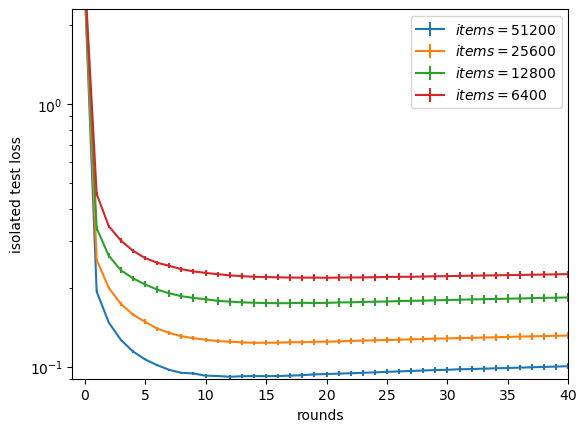

In [743]:
fig, ax = plt.subplots()

for items, test_loss in isolated_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.errorbar(
            x=np.arange(max_len),
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            label=f"$items={items}$")
    print(items, np.min(np.mean(loss, axis=0)))
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("isolated test loss")
ax.set_xlim(-1, 40)
ax.set_ylim(9e-2, np.log(10))
ax.legend()
fig.savefig("figures/isolated_test_loss_scaling_items.pdf")

# Scaling with degree

In [820]:
degree_test_losses = {}

for degree in [32, 16, 8, 4, 3, 2]:
    files = pathlib.Path("logs/networks/regular/").glob(f"nodes-64-degree-{degree}-seed-*-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl")
    for logfile in tqdm(list(files)):
        with open(logfile) as f:
            test_loss = []
            for line in f:
                j = json.loads(line, cls=decoder.TorchTensorDecoder)
                test_loss.append(np.mean(list(j["test_losses"].values())))
            if degree not in degree_test_losses:
                degree_test_losses[degree] = []
            degree_test_losses[degree].append(test_loss)
# rounds = rounds[:128]

100%|██████████| 6/6 [03:03<00:00, 30.55s/it]


32 0.2465536825489511
16 0.24775436184698288
8 0.2487542546948923
4 0.252746888797639
3 0.26115910605603326
2 0.40258724098886994


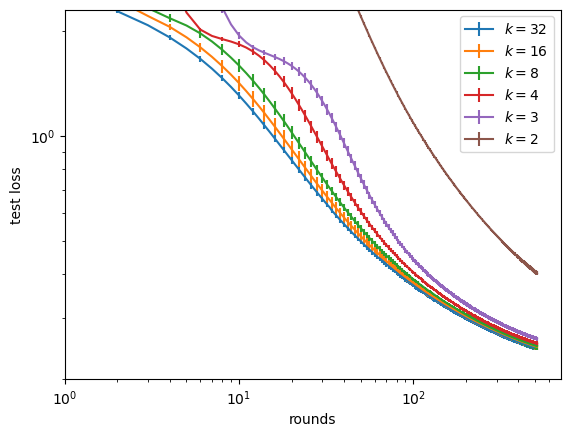

In [821]:
fig, ax = plt.subplots()

for degree, test_loss in degree_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.errorbar(
            x=np.arange(max_len),
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=2,
            label=f"$k={degree}$")
    print(degree, np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.set_xlim(1, None)
ax.set_ylim(2e-1, np.log(10))
ax.legend()
fig.savefig("figures/test_loss_scaling_degree.pdf")

32 0.2465536825489511
16 0.24775436184698288
8 0.2487542546948923
4 0.252746888797639
3 0.26115910605603326
2 0.40258724098886994


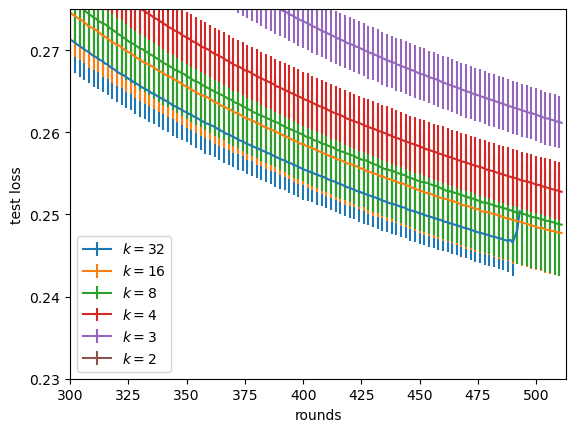

In [822]:
fig, ax = plt.subplots()

for degree, test_loss in degree_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.errorbar(
            x=np.arange(max_len),
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=2,
            label=f"$k={degree}$")
    print(degree, np.min(np.nanmean(loss, axis=0)))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.set_xlim(300, 513)
ax.set_ylim(2.3e-1, 2.75e-1)
ax.legend()
fig.savefig("figures/test_loss_scaling_degree.pdf")

# Scaling with items

In [823]:
items_test_losses = {}

for items in [800, 400, 200, 100]:
    files = pathlib.Path("logs/networks/regular/").glob(f"nodes-64-degree-32-seed-*-heterogenous-init-4-epochs-simple-balanced_iid-{items}-items.jsonl")
    for logfile in tqdm(list(files)):
        with open(logfile) as f:
            test_loss = []
            for line in f:
                j = json.loads(line, cls=decoder.TorchTensorDecoder)
                test_loss.append(np.mean(list(j["test_losses"].values())))
            if items not in items_test_losses:
                items_test_losses[items] = []
            items_test_losses[items].append(test_loss)
# rounds = rounds[:128]

100%|██████████| 18/18 [09:21<00:00, 31.20s/it]


800 0.11193387858036585
400 0.15111272278680116
200 0.20530817622896672
100 0.2465536825489511


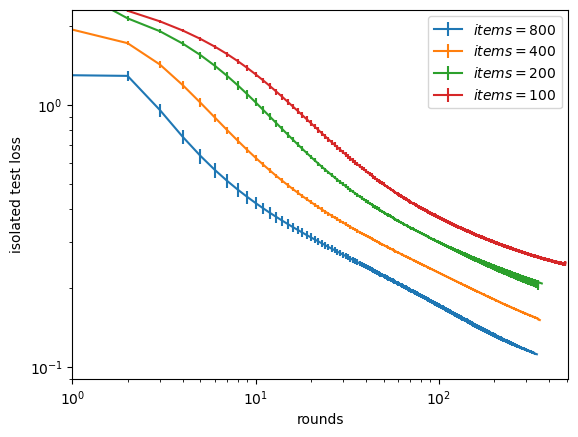

In [824]:
fig, ax = plt.subplots()

for items, test_loss in items_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.errorbar(
            x=np.arange(max_len),
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            label=f"$items={items}$")
    print(items, np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("isolated test loss")
ax.set_xlim(1, 512)
ax.set_ylim(9e-2, np.log(10))
ax.legend()
fig.savefig("figures/test_loss_scaling_items.pdf")

# Homogeneous init

In [805]:
logfile = "logs/networks/regular/nodes-64-degree-32-seed-0-homogeneous-init-4-epochs-simple-balanced_iid-100-items.jsonl"

rounds = []
with open(logfile) as f:
    for line in f:
        rounds.append(json.loads(line, cls=decoder.TorchTensorDecoder))
# rounds = rounds[:128]
print(len(rounds))

170


Text(0, 0.5, 'STD[params] in each node')

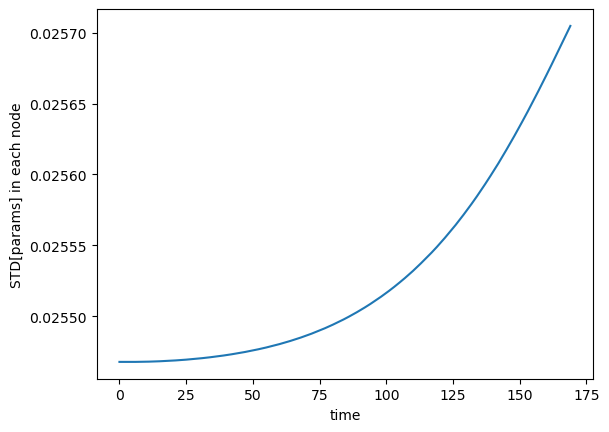

In [808]:
x = [r["round"] for r in rounds]
y = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
plt.plot(x, np.array(y))
# plt.ylim(0, None)
# plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

Text(0, 0.5, 'STD[param] across node')

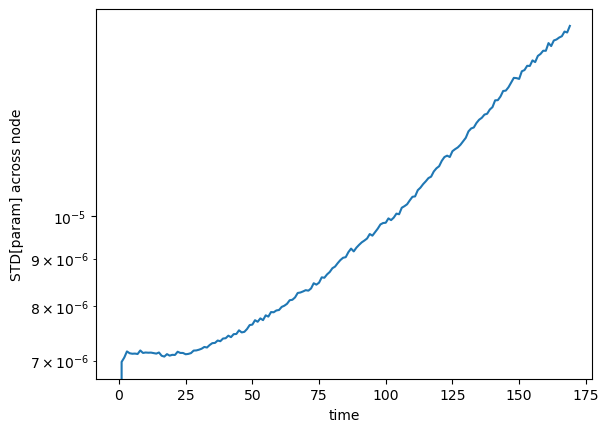

In [809]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x, y)
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

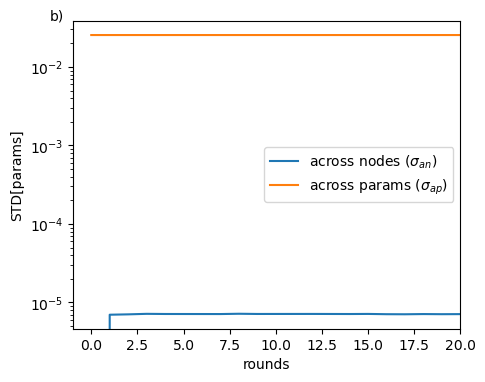

In [811]:
fig, ax = plt.subplots(figsize=(5, 4))
x = [r["round"] for r in rounds]
y_ap = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
y_an = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]

ax.plot(x, np.array(y_an), label="across nodes ($\\sigma_{an}$)")
ax.plot(x, np.array(y_ap), label="across params ($\\sigma_{ap}$)")
ax.set_xlim(-1, 20)
# ax.set_ylim(2e-5, 7e-1)
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("STD[params]")
ax.text(-0.06, 1.0, "b)", transform=ax.transAxes)
fig.savefig("figures/homogeneous_params_stds.pdf")

Text(0, 0.5, '$|\\delta(param)|$')

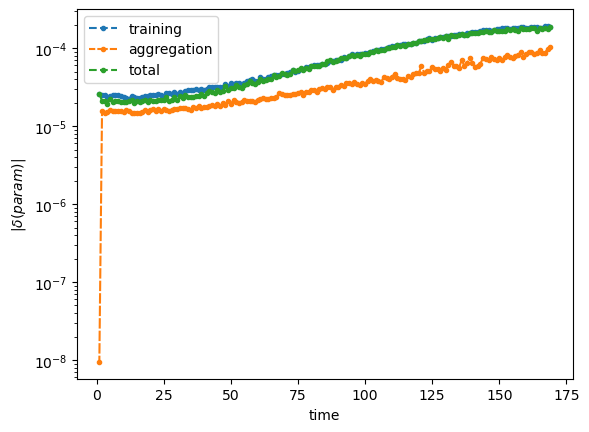

In [812]:
x = [r["round"] for r in rounds[1:]]
y1 = [r["training_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y2 = [r["aggregation_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y3 = [(r["aggregation_changes"]['0']["fc4.weight"] + r["training_changes"]['0']["fc4.weight"]).abs().mean()
      for r in rounds[1:]]
plt.plot(x, y1, label="training", marker=".", ls='--')
plt.plot(x, y2, label="aggregation", marker=".", ls=(2, (5, 1)))
plt.plot(x, y3, label="total", marker=".", ls='--')
plt.yscale("log")
plt.legend()
plt.xlabel("time")
plt.ylabel("$|\delta(param)|$")

1.228008575692773

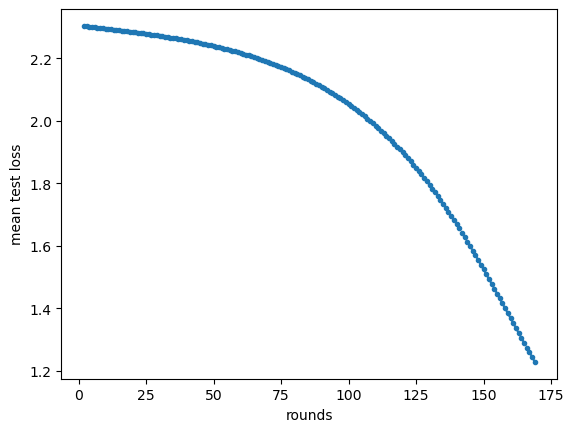

In [813]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_losses"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[2:], y[2:], yerr=yerr[2:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test loss")
y[-1]

Text(0, 0.5, 'mean test accuracy')

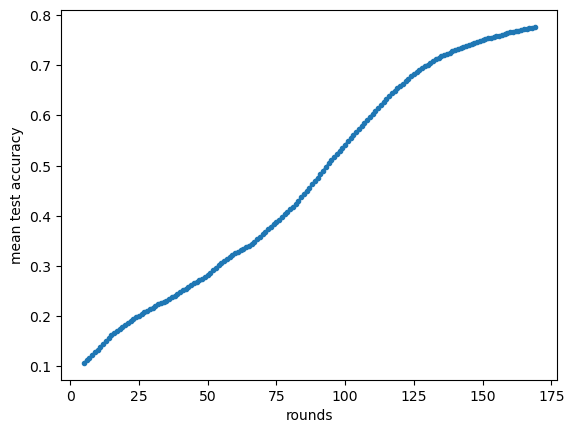

In [814]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_accuracies"])
y = np.array([np.mean([r["test_accuracies"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_accuracies"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[5:], y[5:], yerr=yerr[5:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test accuracy")

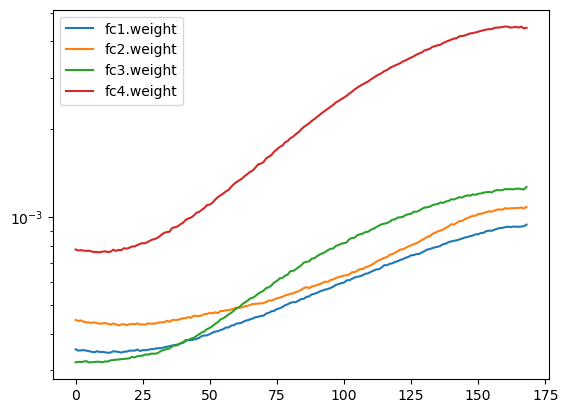

In [815]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    du = []
    for r in rounds[1:]:
        du.append([
            (r["training_changes"][n][param].std()/r["params"][n][param].std()).tolist()
            for n in nodes])
    ax.plot(np.mean(du, axis=1), label=param)
ax.legend()
ax.set_yscale("log")

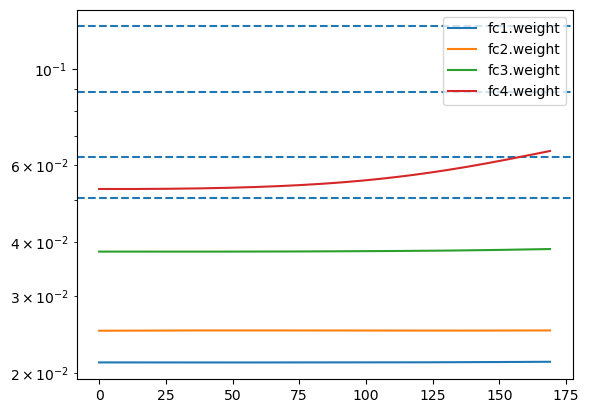

In [816]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
fan_ins = {"fc1.weight": 784, "fc2.weight": 512, "fc3.weight": 256, "fc4.weight": 128}
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    stds = []
    for r in rounds:
        weights = []
        for n in nodes:
            weights.extend(r["params"][n][param].tolist())
        stds.append(np.std(weights))
    ax.plot(stds, label=param)
    ax.axhline((2/fan_ins[param])**0.5, ls='--')
    
ax.set_yscale("log")
ax.legend()